Volume Fraction 0.700
Box Dimensions 15.184
Loaded data...
0.0001 1.0 6.52689730158
0.0002 1.0 6.52661636676
0.0003 1.0 6.52665548349
0.0005 1.0 6.52549518543
0.001 1.0 6.51950220116
0.002 1.0 6.50910384886
0.003 1.0 6.49541964644
0.005 1.0 6.46477360283
0.01 1.0 6.37915476897
0.032 3.0 17.7745080688
0.055 10.0 53.2665924286
0.1 30.0 125.927157507
0.18 58.0 176.046054291
0.22 81.0 210.694602293
0.32 312.0 385.268683802
0.46 357.0 324.844672201
0.55 391.0 290.551759645
1.0 446.0 182.70080288
1.8 491.0 122.861277647
3.2 560.0 73.7787439812
10.0 620.0 25.0483147253


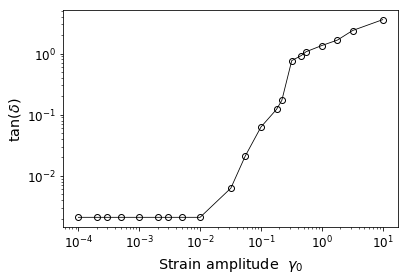

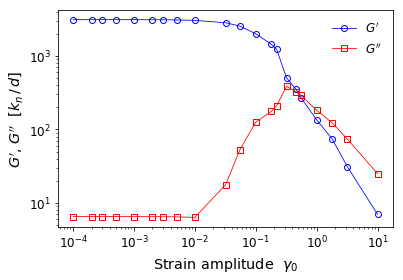

Time: 24.078 s
Completed...
Time: 24.079 s


In [2]:
import time
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
from os import listdir
import re
start = time.time()
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


# function to read datafile
def get_all_data(filename):
# read text file and store each line as element of list
    with open(filename) as f:
        raw = f.readlines()
        f.close()
    raw = [x.strip() for x in raw]
    
    s = 0
    e = len(raw) - 1
    for k in range(len(raw)):
        if 'Time' in raw[k]:
            s = k + 1
        elif 'Loop' in raw[k]:
            e = k - 1
    #print(e - s)

# create array of data for each timestep
    all_data = []
# discards first and last info lines and split each line of data into a list of floats
    for j in range(len(raw)):
        if s <= j <= e:
            all_data.append(list(map(float, raw[j].split())))
            
    return all_data


# function to execute main part of the code
def extract_data(file, data_path):

# extracts time, contact and hydro stresses and strain from datafile
    datafile = '%s/%s' % (data_path, file)
    all_data = get_all_data(datafile)
    
    t = np.zeros(len(all_data))
    sc_xz = np.zeros(len(all_data))
    sh_xz = np.zeros(len(all_data))
    #strain = np.zeros(len(all_data))
    
    for i in range(len(all_data)):
        t[i] = all_data[i][0]
        sc_xz[i] = -all_data[i][1]
        sh_xz[i] = -all_data[i][2]
        #strain[i] = all_data[i][7]

    return t, sc_xz, sh_xz


def tryfloat(s):
    try:
        return float(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[14:-4]
    breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return float(amp)
    

def calc_signal_lag(a_sig, b_sig, thermo_nt):
    lag = np.argmax(correlate(a_sig, b_sig, mode='full'))
    steps = int(period / (timestep * thermo_nt))
    mod_lag = lag % steps
    if mod_lag > int(steps/2) or mod_lag == 0:
        mod_lag = 1.0
        
    return mod_lag


def plot_signals_vs_time(t, a_sig, b_sig, lag, phase_diff, shear_amp, fig_path, l1, l2):
    # shifts strain by lag to check if aligned with stress now
    c_sig = np.roll(b_sig, shift = -lag)

    plt.figure()
    #plt.title('Stress and Strain vs Time for Shear Amplitude: %g' % (shear_amp))
    plt.plot(t[l1:l2] / period, a_sig[l1:l2], color='blue', label=r'$\sigma \, / \, \sigma_0$')
    plt.plot(t[l1:l2] / period, b_sig[l1:l2], color='red', label=r'$\varepsilon\, / \, \varepsilon_0$')
    #plt.plot(t[l1:l2], c_sig[l1:l2], color='green', label='Shifted Strain', alpha=0.5)
    plt.xlabel(r'Shear cycles $n$')
    plt.ylabel(r'$\sigma \, / \, \sigma_0$, $\varepsilon\, / \, \varepsilon_0$')
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.savefig('%s/stress_strain_vs_t_%s.png' % (fig_path, shear_amp), bbox_inches='tight')
    plt.close()
    
    return None


def plot_stress_vs_strain(stress, strain, shear_amp, fig_path, l1, l2):
    
    plt.figure(figsize=(6, 6))
    #plt.title('Stress-strain plot for shear amplitude: %g' % (shear_amp))
    plt.plot(strain[l1:l2], stress[l1:l2], color='blue')
    plt.ylabel(r'$\sigma \, / \, \sigma$')
    plt.xlabel(r'$\varepsilon\, / \, \varepsilon_0$')
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)
    #plt.axes().set_aspect('equal', 'datalim')
    plt.savefig('%s/stress_vs_strain_%s.png' % (fig_path, shear_amp), bbox_inches='tight')
    plt.close()
    
    #how to make it square
    '''fig = figure(figsize=(6, 6), dpi=100) 
    ax = fig.add_subplot(1,1,1) 
    [... plotting commands] 
    ax.set_aspect('equal', adjustable='box') 
    fig.savefig('mysquarefig.png', dpi=100) '''
    
    return None


def calc_macro_reversibility(vol_frac, box_dim):
    print('Volume Fraction %.3f' % vol_frac)
    print('Box Dimensions %g' % box_dim)
    
    data_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data/volume_fraction_%.3f' % vol_frac
    fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/volume_fraction_%.3f' % vol_frac
    all_files = listdir(data_path)
    files = []
    for file in all_files:
        if ".log" in file and "repeat" not in file and "large" not in file and "super" not in file:
            files.append(file)

    files.sort(key=alphanum_key)

    shear_amps = np.zeros(len(files))
    for i in range(len(files)):
        shear_amps[i] = (float(files[i][14:-4]))

    ts = []
    sc_xzs = []
    sh_xzs = []
    strains = []
    shear_rates = []
    stokes_nos = np.zeros(len(files))
    total_stresses = []
    norm_strains = []
    norm_stresses = []

    for i in range(len(files)):
        
        #print('Shear Amplitude: %s' % shear_amps[i])
        t, sc_xz, sh_xz = extract_data(files[i], data_path)
        strain = shear_amps[i] * np.sin(freq * t)
        ts.append(t)
        sc_xzs.append(sc_xz)
        sh_xzs.append(sh_xz)
        strains.append(strain)
        shear_rates.append(freq * shear_amps[i] * np.cos(freq * t))
        stokes_nos[i] = (density * np.absolute(shear_rates[i]).max() * particle_r ** 2) / viscosity
        total_stress = sc_xz + sh_xz
        norm_strains.append(strain / np.absolute(strain[exclude:]).max())
        mean_stress = np.mean(total_stress[exclude:])
        total_stress -= mean_stress
        total_stresses.append(total_stress)
        norm_stresses.append((total_stress) / np.absolute(total_stress[exclude:]).max())
    
    ts = np.array(ts)
    sc_xzs = np.array(sc_xzs) # xz component of contact stresses
    sh_xzs = np.array(sh_xzs) # xz component of hydrodynamic stresses
    strains = np.array(strains)
    shear_rates = np.array(shear_rates)
    total_stresses = np.array(total_stresses)
    norm_strains = np.array(norm_strains) # normalised shear strains
    norm_stresses = np.array(norm_stresses) # normalised hydrodynamic stresses
    
    #print('Shear Amplitudes: %a' % (np.array(shear_amps) / box_dim))
    #print('Stokes Numbers: %a' % stokes_nos)
    #print('Shear Rate Amplitudes: %a' % (np.array(shear_amps) / box_dim * freq))
    print('Loaded data...')
    
    lags = np.zeros(len(shear_amps))
    lag_times = np.zeros(len(shear_amps))
    phase_diffs = np.zeros(len(shear_amps))
    loss_moduli = np.zeros(len(shear_amps))
    storage_moduli = np.zeros(len(shear_amps))

    for i in range(len(shear_amps)):
        if shear_amps[i] in precise:
            thermo_nt = 25
        else:
            thermo_nt = 1000
        l1 = - int(3 * period / (timestep * thermo_nt)) # lower limit index for plots (3 cycles)
        l2 = -1 # upper limit index for plots
        lags[i] = calc_signal_lag(norm_strains[i][l1:], norm_stresses[i][l1:], thermo_nt)
        lag_times[i] = lags[i] * (timestep * thermo_nt)
        phase_diffs[i] = (freq * lag_times[i]) % (2 * np.pi)
        loss_moduli[i] = (np.absolute(total_stresses[i][l1:]).max() / np.absolute(strains[i][l1:]).max()) * np.sin(phase_diffs[i])
        storage_moduli[i] = (np.absolute(total_stresses[i][l1:]).max() / np.absolute(strains[i][l1:]).max()) * np.cos(phase_diffs[i])
        print(shear_amps[i], lags[i], loss_moduli[i])
        
    for i in range(len(shear_amps)):
        #print('Shear Amplitude: %g' % shear_amps[i])
        #print('Phase difference: %g pi' % (phase_diffs[i] / np.pi))
        #print('Loss Modulus: %g' % loss_moduli[i])
        #print('Storage Modulus: %g\n' % storage_moduli[i])
        plot_stress_vs_strain(norm_stresses[i][3:], norm_strains[i][3:], shear_amps[i], fig_path, l1, l2)
        plot_signals_vs_time(ts[i], norm_stresses[i], norm_strains[i], int(lags[i]), phase_diffs[i], shear_amps[i], fig_path, l1, l2)

    
    mod_fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/complex_moduli'
    tan_delta = loss_moduli / storage_moduli # ratio of loss to storage
    
    x = np.log(shear_amps)
    y = np.log(np.absolute(tan_delta))
    '''
    coeff = np.polyfit(x[3:-1], y[3:-1], 6)
    xx = np.linspace(x[4], x[-3], 1000)
    yy = coeff[-1] + coeff[-2] * xx + coeff[-3] * xx**2 + coeff[-4] * xx**3 + coeff[-5] * xx**4 + coeff[-6] * xx**5 + coeff[-7] * xx**6
    #trans_arg = np.argmin(np.absolute(np.gradient(np.gradient(yy, xx))))
    trans_arg = np.argmin(np.gradient(yy, xx))
    #trans_arg = np.argmin(yy)
    print('Transition Amplitude: %.3f' % np.exp(xx[trans_arg]))
    '''
    slope, intercept = np.polyfit(x[:3], y[:3], 1)
    x_init = np.linspace(x[0], x[-1], 1000)
    y_init = intercept + slope * x_init
    
    plt.figure()
    #plt.loglog(np.exp(xx), np.exp(yy), color='red', alpha=0.5, lw=2)
    #plt.loglog([np.exp(xx[trans_arg])], [np.exp(yy[trans_arg])], 's', color='green')
    #plt.loglog(np.exp(x_init), np.exp(y_init), color='red', alpha=0.5, lw=1.6)
    plt.loglog(shear_amps, abs(tan_delta), marker='o', color='black', mfc='none', lw=0.8)
    #plt.ylim(1e1, 2e1)
    plt.xlabel(r'Strain amplitude  $\gamma_0$')
    #plt.ylabel(r'$G^{\prime \prime} \, / \, G^{\prime}$')
    plt.ylabel(r'$\tan(\delta)$')
    #plt.title('Ratio of loss/storage moduli for volume fraction: %.3f' % vol_frac)
    plt.savefig('%s/log_ratio_of_moduli_%.3f.png' % (mod_fig_path, vol_frac), dpi=500, bbox_inches='tight')
    plt.show()
    

    plt.figure()
    plt.loglog(shear_amps, abs(storage_moduli), marker='o', color='blue', mfc='none', label=r'$G^{\prime}$', lw=0.8)
    plt.loglog(shear_amps, abs(loss_moduli), marker='s', color='red', mfc='none', label=r'$G^{\prime\prime}$', lw=0.8)
    plt.xlabel(r'Strain amplitude  $\gamma_0$')
    plt.ylabel(r'$G^{\prime}$, $G^{\prime\prime}$  $[k_n\, / \, d]$')
    #plt.title('Dynamic moduli for volume fraction: %.3f' % vol_frac)
    plt.legend(loc=0)
    plt.legend(frameon=False)
    plt.savefig('%s/log_complex_moduli_%.3f.png' % (mod_fig_path, vol_frac), dpi=500, bbox_inches='tight')
    plt.show()
    
    '''plt.figure()
    plt.plot(shear_amps, abs(tan_delta), marker='o', color='black', mfc='none', lw=0.8)
    plt.ylim(0)
    plt.xlabel('Shear Amplitude')
    plt.ylabel('Loss/Storage Modulus')
    plt.title('Ratio of loss/storage moduli for volume fraction: %.3f' % vol_frac)
    plt.savefig('%s/ratio_of_moduli_%.3f.png' % (mod_fig_path, vol_frac), bbox_inches='tight')
    plt.close()
    
    plt.figure()
    plt.plot(shear_amps, abs(loss_moduli), marker='s', color='red', mfc='none', label='Loss Modulus', lw=0.8)
    plt.plot(shear_amps, abs(storage_moduli), marker='o', color='blue', mfc='none', label='Storage Modulus', lw=0.8)
    plt.ylim(0)
    plt.xlabel('Shear Amplitude')
    plt.ylabel('Shear Modulus')
    plt.title('Loss and storage moduli for volume fraction: %.3f' % vol_frac)
    plt.legend(loc=0)
    plt.savefig('%s/complex_moduli_%.3f.png' % (mod_fig_path, vol_frac), bbox_inches='tight')
    plt.close()'''
    
    '''if vol_frac == 0.7:
        print(loss_moduli)'''
    
    print('Time: %.3f s' % (time.time()-start))
    
    return None
    
    
def get_vol_fracs(path):
    all_folders = listdir(path)
    vol_fracs = []
    for folder in all_folders:
        if 'volume_fraction_' in folder:
            vol_fracs.append(float(folder[16:]))
    return vol_fracs
    
    

### code to be executed ###

path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data'
vol_fracs = get_vol_fracs(path)
vol_fracs = np.array([0.647, 0.648, 0.649, 0.650, 0.660, 0.680, 0.700])
vol_fracs = np.array([0.700])
precise = [0.00011, 0.00101, 0.01001, 0.00301]

timestep = 0.00032149
thermo_nt = 1000 # number of timesteps between each output on log files
period = 964.47
density = 1.0
viscosity = 0.1
particles = 2500
particle_r = 0.6
freq = 2 * np.pi / period
exclude = int(period / (timestep * thermo_nt))

for vol_frac in vol_fracs:
    box_dim = round((1250 * (4 / 3) * np.pi * (0.7 ** 3 + 0.5 ** 3) / vol_frac) ** (1 / 3) * 1000) / 1000
    calc_macro_reversibility(vol_frac, box_dim)

end = time.time()
print('Completed...\nTime: %.3f s' % (end-start))


In [ ]:
%%file plot_macro.py

start = time.time()

def calc_signal_lag(a_sig, b_sig):
    lag = np.argmax(correlate(a_sig, b_sig, mode='full'))
    
    return lag


def plot_signals_vs_time(t, a_sig, b_sig, lag, phase_diff, shear_amp, fig_path, l1, l2):
    # shifts strain by lag to check if aligned with stress now
    c_sig = np.roll(b_sig, shift = -lag)

    plt.figure()
    plt.title('Stress and Strain vs Time for Shear Amplitude: %g' % (shear_amp / box_dim))
    plt.plot(t[l1:l2], a_sig[l1:l2], color='blue', label='Hydro Stress')
    plt.plot(t[l1:l2], b_sig[l1:l2], color='green', label='Strain')
    plt.plot(t[l1:l2], c_sig[l1:l2], color='red', label='Shifted Strain', alpha=0.5)
    plt.xlabel('t')
    plt.ylabel('Stress')
    plt.legend(loc='best')
    plt.savefig('%s/stress_strain_vs_t_%s.png' % (fig_path, shear_amp), bbox_inches='tight')
    plt.close()
    
    return None


def plot_stress_vs_strain(stress, strain, shear_amp, fig_path):
    
    plt.figure()
    plt.title('Stress vs Strain for Shear Amplitude: %g' % (shear_amp / box_dim))
    plt.plot(strain, stress, color='blue')
    plt.xlabel('Normalised Strain')
    plt.ylabel('Normalised Hydrodynamic Stress')
    plt.savefig('%s/stress_vs_strain_%s.png' % (fig_path, shear_amp), bbox_inches='tight')
    plt.close()
    
    return None

#def plot_()


### code to be executed ###

l1 = 0 # lower limit index for plots
l2 = int(4 * period / timestep) # upper limit index for plots
lags = np.zeros(len(shear_amps))
lag_times = np.zeros(len(shear_amps))
phase_diffs = np.zeros(len(shear_amps))
loss_moduli = np.zeros(len(shear_amps))
storage_moduli = np.zeros(len(shear_amps))

for i in range(len(shear_amps)):
    lags[i] = calc_signal_lag(norm_strains[i], norm_stresses[i])
    lag_times[i] = lags[i] * timestep
    phase_diffs[i] = (freq * lag_times[i]) % (2 * np.pi)
    loss_moduli[i] = (np.absolute(total_stresses[i]).max() / np.absolute(strains[i]).max()) * np.sin(phase_diffs[i])
    storage_moduli[i] = (np.absolute(total_stresses[i]).max() / np.absolute(strains[i]).max()) * np.cos(phase_diffs[i])

for i in range(len(shear_amps)):
    print('Shear Amplitude: %g' % shear_amps[i])
    #print('Phase difference: %g pi' % (phase_diffs[i] / np.pi))
    #print('Loss Modulus: %g' % loss_moduli[i])
    #print('Storage Modulus: %g\n' % storage_moduli[i])
    plot_stress_vs_strain(norm_stresses[i], norm_strains[i], shear_amps[i], fig_path)
    plot_signals_vs_time(ts[i], norm_stresses[i], norm_strains[i], int(lags[i]), phase_diffs[i], shear_amps[i], fig_path, l1, l2)

    
    

mod_fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/complex_moduli'

tan_delta = loss_moduli / storage_moduli # ratio of loss to storage
plt.figure()
plt.semilogy(np.array(shear_amps) / box_dim, abs(tan_delta), '.')
plt.xlabel('Shear Amplitude')
plt.ylabel('Loss/Storage Modulus')
plt.savefig('%s/ratio_of_moduli_%.3f.png' % (mod_fig_path, vol_frac), bbox_inches='tight')

plt.figure()
plt.semilogy(np.array(shear_amps) / box_dim, abs(loss_moduli), color='red', label='Loss Modulus')
plt.semilogy(np.array(shear_amps) / box_dim, abs(storage_moduli), color='blue', label='Storage Modulus')
plt.xlabel('Shear Amplitude')
plt.ylabel('Shear Modulus')
plt.legend(loc=0)
plt.savefig('%s/complex_moduli_%.3f.png' % (mod_fig_path, vol_frac), bbox_inches='tight')

plt.show()
#vol_frac += 0.01

end = time.time()
print('Completed...\nTime: %f s' % (end-start))